> **Note**
> The parent folder of this notebook is assumed to be the current working directory.

Import libraries...

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

ENV_PATH = str(Path.cwd().parent)
if ENV_PATH not in sys.path:
    sys.path.insert(0, ENV_PATH)
from detectors.load import load_detector
from utils import plotting


Some helpful functions...

In [2]:
def overlay_hm(im, hm, cmap='Blues', hm_up=True, no_border=None):
    """ Overlay score maps over image """
    h, w = im.shape[:2]
    i, j = np.indices((h, w))

    m = i <= j * h / w if hm_up else i > j * h / w

    if no_border is None:
        no_border = (slice((aux := 20), -aux), slice(aux, -aux))

    # clip heatmap values to [0, 1] range.
    vmin, vmax = hm[no_border].min(), hm[no_border].max()
    hm1 = (hm - vmin).clip(0, vmax - vmin) / (vmax - vmin)

    out = im.copy()
    out[m] = (255 * plt.get_cmap(cmap)(hm1[m])[:, :-1]).astype(im.dtype)
    return out


def plot_iso_covs(bg, kps, scores, axi=None, **kwargs):
    """ Istropic covariances (directly based on the scores) """
    inv_covs_iso = np.repeat(
        np.eye(2)[None], kps.shape[1], 0) * scores[:, None, None]

    out = plotting.plot_ellipses(
        bg,
        kps,
        inv_covs_iso,
        axi=axi,
        **kwargs
    )
    
    return out


def load_im(name, max_size=None):
    im = Image.open(Path().resolve() / f'images/{name}')
    if max_size is not None:
        # resize while preserving aspect ratio
        im.thumbnail((max_size, max_size), Image.Resampling.LANCZOS)
    im = np.array(im.convert('RGB'))

    # ensure dimensions are divisible by 8.
    h, w = im.shape[:2]
    return im[:h - h % 8, :w - w % 8]


def run_model(model, im):
    """ get local features along with covariances and scores map """
    name = model.__class__.__name__.lower()

    if name == 'superpoint':
        kps, desc, inv_covs, hms = model(im)
        return kps, desc, inv_covs, hms[0]

    elif name == 'd2net':
        kps, desc, inv_covs, hms, kps_hm = model(im)

        # return kps belonging to the spatial heatmap with most local features.
        chs, counts = np.unique(kps_hm[0].astype(int), return_counts=True)
        ch = chs[counts.argmax()]
        mask = kps_hm[0] == ch

        kps = kps[:, mask]
        desc = desc[mask]
        inv_covs = inv_covs[mask]

        return kps, desc, inv_covs, cv2.resize(
            hms[ch], im.shape[1::-1], interpolation=cv2.INTER_NEAREST)

    elif name == 'r2d2':
        kps, desc, inv_covs, hms, kps_hm = model(im)
        kps_hm = kps_hm[1::-1]

        # local features in the heatmap.
        mask = (kps[None, :2].T == kps_hm).all(1).any(1)
        kps = kps[:, mask]
        desc = desc[mask]
        inv_covs = inv_covs[mask]

        return kps, desc, inv_covs, hms[0]

    elif name == 'keynet':
        kps, desc, inv_covs, hms, kps_hm = model(im)
        kps_hm = kps_hm[1::-1]

        # local features in the heatmap with enough qualitative score value.
        mask = (kps[None, :2].T == kps_hm).all(1).any(1) & (kps[2] > 1000)
        kps = kps[:, mask]
        desc = desc[mask]
        inv_covs = inv_covs[mask]

        return kps, desc, inv_covs, hms

    else:
        raise ValueError


Select image and deep detector.

In [3]:
# instanciate deep model
model_name = 'd2net' # {d2net, keynet, r2d2, superpoint}
model = load_detector(model_name, {'return_heatmaps': True})

In [4]:
# select and load image. Images are expected to be stored at ./images folder.
image_name = 'pont.jpg'
im = load_im(image_name, max_size=640)

Run model on the input image and visualize a uniform sample of detections along with their spatial covariances.

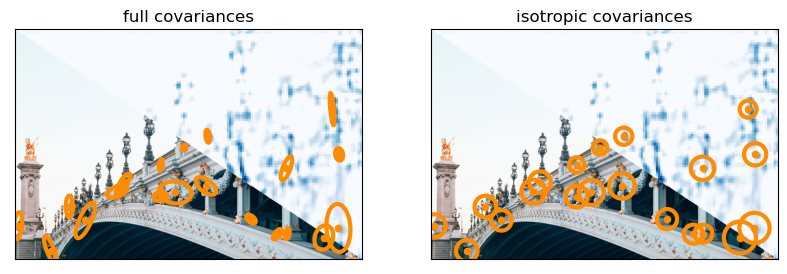

In [5]:
# configuration for plotting.
cfg_viz = {
    "c": (255, 140, 0), # dark orange
    "do_filtering": False, # filter extreme uncertainties
    "n": 20, # number of features to plot
    "set_scale_w": "median",
    "scale": 20, # `set_scale_w` size of the uncertainty ellipses.
    "radius": 10, # detection size when plotting it.
}

kps, _, inv_covs, hm = run_model(model, im)

# overlay score map on image
bg = overlay_hm(im, hm, cmap='Blues', hm_up=True)

fig, axes = plt.subplots(1, 2)

# plot full covariances
plotting.plot_ellipses(
    bg, kps[:2], inv_covs, lib='plt', axi=axes[0],
    **cfg_viz)

# plot isotropic covariances
plot_iso_covs(bg, kps[:2], kps[2], axi=axes[1],
              **{**cfg_viz, **{'lib': 'plt'}})

axes[0].set(title='full covariances')
axes[1].set(title='isotropic covariances')

plt.show()